In [2]:
import sqlite3
import pandas as pd
import string
import pickle
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [3]:
def cumsum_sample(data):
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    # all of the above are unbiased estimations of the CDF
    # p = 1. * np.arange(len(data)) / (len(data) - 1)
    # p = (arange(len(x))+0.5)/len(x)
    p = np.linspace(0, 1, len(data), endpoint=False)
    return data_sorted, p

In [4]:
####################################
# Load data exam_list and predictions from model
####################################

data_path = '../sample_output/data.pkl'
pred_path = '../sample_output/image_predictions.csv'

# read exam_list from the NYU output. It is a list of dictionaries, one per exam.
with open(data_path, 'rb') as handle:
    exam_list_dict = pickle.load(handle)

# read predictions
pred_full = pd.read_csv(pred_path, sep=',')


exam_id_list = []
# substring = substring.replace("-", ' ')
for dic in exam_list_dict:
    exam_id_list.append( dic['L-CC'][0].split('_')[0] )


pred_full['exam_id'] = exam_id_list


In [8]:
####################################
# Read reports from sqlite3 and extract labels
####################################

# Create your connection.
conn = sqlite3.connect(r'../dicom_CRO/reports.db')

# change encoding to latin. Default is utf-8
conn.text_factory = lambda x: str(x, 'latin1')
# conn.text_factory = bytes

# reads table and transforms it into dataframe
df = pd.read_sql_query("SELECT * FROM reports", conn)

# key_words to filter the reports
key_word_1 = 'RADS'
key_word_2 = 'intervento'

interv_list = []
birad_list = []
for i,row in df.iterrows():

    pat_id = row['PZ'] 

    index = row['REPORT'].find(key_word_2)
    if index >=0:
        interv_list.append((pat_id, 1))


    # PI: loop to find all BI-RADS occurence in the report
    index = row['REPORT'].find(key_word_1)
    substring = row['REPORT'][index:index+15]
    # remove punctuations
    substring = substring.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    # substring = substring.replace("-", ' ')
    # substring = substring.replace(')', ' ')

    # adhoc replaces based on what I saw in the data
    substring = substring.replace('S', ' ')
    substring = substring.replace('n', ' ')
    substring = substring.replace('a', ' ')
    substring = substring.replace('b', ' ')
    substring = substring.replace('c', ' ')
    birad = [int(s) for s in substring.split() if s.isdigit()]

    if len(birad):
        birad = sum(birad) / len(birad)
        birad_list.append((pat_id, birad))

# print(birad_list)
print(f'birad_list len: {len(birad_list)}')

birad_list len: 51


In [9]:
####################################
# Add birad and intervento columns to pred_full dataframe
####################################


pred_full['birad'] = None
for pat_id, birad in birad_list:
    pred_full.loc[pred_full['exam_id'] == pat_id, 'birad'] = birad


pred_full['intervento'] = 0
for pat_id, interv in interv_list:
    pred_full.loc[pred_full['exam_id'] == pat_id, 'intervento'] = interv


# prediction dataframe without birad nulls
pred = pred_full[pred_full["birad"].notnull()]
print(pred)


    left_benign  right_benign  left_malignant  right_malignant  exam_id birad  \
0        0.0964        0.3200          0.0202           0.1402   265813     6   
1        0.3611        0.2552          0.0583           0.0209  5023655     2   
2        0.1571        0.3589          0.0212           0.0825   132796   1.5   
3        0.2275        0.3500          0.0269           0.0618  2329861   1.5   
4        0.1642        0.1803          0.0344           0.0715   302492   1.5   
5        0.2314        0.2114          0.0577           0.0549   148400   1.5   
6        0.3221        0.3754          0.0448           0.0381  3409755     4   
7        0.2486        0.3535          0.0246           0.0271   214004     3   
8        0.1431        0.1757          0.0282           0.0469   289093   1.5   
9        0.2255        0.3906          0.0356           0.0922  5060115     4   
10       0.0927        0.1497          0.0239           0.0478   424007     3   
11       0.1372        0.240

NameError: name 'model' is not defined

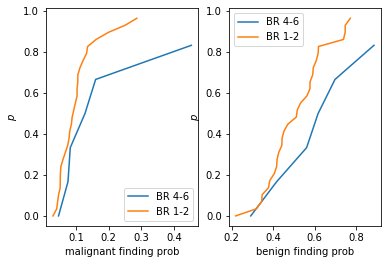

In [10]:
####################################
# Plots
####################################

label = 'malignant'
pred_1_2 = pred[pred['birad'] < 2.5 ]['left_'+label] + pred[pred['birad'] < 2.5 ]['right_'+label]
pred_3_4 = pred[ (pred['birad'] >= 2.5) & (pred['birad'] < 4.5) ]['left_'+label] + pred[ (pred['birad'] >= 2.5) & (pred['birad'] < 4.5) ]['right_'+label]
pred_5_6 = pred[ pred['birad'] >= 4.5 ]['left_'+label] + pred[ pred['birad'] >= 4.5 ]['right_'+label]

pred_4_6 = pred[ pred['birad'] >= 3.5 ]['left_'+label] + pred[ pred['birad'] >= 3.5 ]['right_'+label]
pred_1_3 = pred[ pred['birad'] < 3.5 ]['left_'+label] + pred[ pred['birad'] < 3.5 ]['right_'+label]


sort_1_2, cumsum_1_2 = cumsum_sample(pred_1_2)
sort_3_4, cumsum_3_4 = cumsum_sample(pred_3_4)
sort_4_6, cumsum_4_6 = cumsum_sample(pred_4_6)
sort_1_3, cumsum_1_3 = cumsum_sample(pred_1_3)


# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(sort_4_6, cumsum_4_6, label = 'BR 4-6')
ax1.plot(sort_1_2, cumsum_1_2, label = 'BR 1-2')
ax1.set_xlabel(label +' finding prob')
ax1.set_ylabel('$p$')
ax1.legend()


label = 'benign'
pred_1_2 = pred[pred['birad'] < 2.5 ]['left_'+label] + pred[pred['birad'] < 2.5 ]['right_'+label]
pred_3_4 = pred[ (pred['birad'] >= 2.5) & (pred['birad'] < 4.5) ]['left_'+label] + pred[ (pred['birad'] >= 2.5) & (pred['birad'] < 4.5) ]['right_'+label]
pred_5_6 = pred[ pred['birad'] >= 4.5 ]['left_'+label] + pred[ pred['birad'] >= 4.5 ]['right_'+label]
pred_4_6 = pred[ pred['birad'] >= 3.5 ]['left_'+label] + pred[ pred['birad'] >= 3.5 ]['right_'+label]
pred_1_3 = pred[ pred['birad'] < 3.5 ]['left_'+label] + pred[ pred['birad'] < 3.5 ]['right_'+label]


sort_1_2, cumsum_1_2 = cumsum_sample(pred_1_2)
sort_3_4, cumsum_3_4 = cumsum_sample(pred_3_4)
sort_4_6, cumsum_4_6 = cumsum_sample(pred_4_6)
sort_1_3, cumsum_1_3 = cumsum_sample(pred_1_3)


ax2 = fig.add_subplot(122)
ax2.plot(sort_4_6, cumsum_4_6, label = 'BR 4-6')
ax2.plot(sort_1_2, cumsum_1_2, label = 'BR 1-2')
ax2.set_xlabel(label + ' finding prob')
ax2.set_ylabel('$p$')
ax2.legend()


fig.suptitle(model + ' model')
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()